# Final comparison of the three methods: 
- Adavanced Image Analysis + Machine Learning (Casacaded SVMs)
- Deep Learning (Detection by classification in sliding window fashion)
- Deep Learning (Detection using Faster RCNN in slidin window fashion)

Mount G-Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import os

# CHANGE ONLY THIS PATH AND EVERYTHING SHOULD RUN
# Vlad's drive
notebooks_path = Path.cwd()/'drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det/notebooks'
# Joaquin's drive
# notebooks_path = Path.cwd()/'drive/MyDrive/calcification_detection/calc-det/notebooks'
repo_path = notebooks_path.parent
os.chdir(str(notebooks_path))

thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Move the files to the localhost to run faster

In [ ]:

inbreast_pngs_path = str(repo_path / 'data/INbreast\ Release\ 1.0/AllPNGs/full_imgs')
inbreast_img_meta_path = str(repo_path / 'data/INbreast\ Release\ 1.0/images_metadata.csv')
inbreast_rois_meta_path = str(repo_path / 'data/INbreast\ Release\ 1.0/rois_metadata.csv')
inbreast_masks_path = str(repo_path / 'data/INbreast\ Release\ 1.0/AllMasks/full_imgs')

det_checkpoints_path = str(repo_path / 'deep_learning/detection_models/checkpoints/')
class_checkpoints_path = str(repo_path / 'deep_learning/classification_models/checkpoints/')

!mkdir '/home/INbreast Release 1.0/'
!mkdir '/home/INbreast Release 1.0/AllPNGs/'
!mkdir '/home/INbreast Release 1.0/AllMasks/'

!rsync -rva $inbreast_pngs_path '/home/INbreast Release 1.0/AllPNGs/'
!rsync -rva $inbreast_img_meta_path '/home/INbreast Release 1.0/images_metadata.csv'
!rsync -rva $inbreast_rois_meta_path '/home/INbreast Release 1.0/rois_metadata.csv'
!rsync -rva $inbreast_masks_path '/home/INbreast Release 1.0/AllMasks/'

!rsync -rva $det_checkpoints_path '/home/detection_checkpoints'
!mv /home/detection_checkpoints/checkpoints/* '/home/detection_checkpoints/'
!rmdir '/home/detection_checkpoints/checkpoints/'
!rsync -rva $class_checkpoints_path '/home/classification_checkpoints'
!mv /home/classification_checkpoints/checkpoints/* '/home/classification_checkpoints/'
!rmdir '/home/classification_checkpoints/checkpoints/'
!pip install -r '../requirements.txt'

Generate the database of images in the test set

In [3]:
from database.dataset import INBreast_Dataset
from metrics.metrics import froc_curve_bootstrap
from general_utils.plots import plot_bootstrap_froc
from sklearn.metrics import auc



db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions=['test'],
    lesion_types=['calcification', 'cluster'],
    cropped_imgs=True,
    keep_just_images_of_lesion_type=False,
    use_muscle_mask=False,
    ignore_diameter_px=15
)

### Create a function to get the detection over a complete dataset

In [4]:
import pickle
import time
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm

from metrics.metrics_utils import get_froc_df_of_img, get_tp_fp_fn_center_patch_criteria

def get_froc_dataframe_from_set(
    db: INBreast_Dataset, detector, results_path: Path, store_time: bool = False,
    algorithm='aia_ml', multiscale=False):
    # get normal images
    normal_imgs_ids = db.get_free_of_selected_lesions_imgs_ids()

    # define paths to store intermediate results
    results_path = Path(results_path)
    if not results_path.exists():
        results_path.mkdir(parents=True, exist_ok=True)
    frocs_df_path = results_path / 'froc_df.csv'
    times_path = results_path / 'times.p'
    froc_dfs = []
    times = []

    # get the detections for each image in the database
    for idx in tqdm(range(len(db))):
        # get sample
        db_sample = db[idx]
        image = db_sample['img']
        image_id = db_sample['img_id']
        image_mask = db_sample['lesion_mask']

        start = time.time()
        detections = detector.detect(image)
        times.append(time.time()-start)

        # reformat detections
        if algorithm == 'aia_ml':
            detections_centers_and_radius = np.stack(
                detections['candidate_coordinates'].values).astype(int)
            detections_scores = detections['confidence'].values.reshape(-1, 1)
            # retain the centers and scores:
            candidates = np.concatenate(
                [detections_centers_and_radius, detections_scores], axis = 1)
        else:
            detections_centers = detections[:, 0:2].astype(int)
            detections_scores = detections[:, -1].reshape(-1, 1)
            detections_radius = np.ones(detections_scores.shape) * 7
            # retain the centers and scores:
            candidates = np.concatenate(
                [detections_centers, detections_radius, detections_scores], axis = 1)

        # compare with labels
        tp, fp, fn, ignored_candidates = get_tp_fp_fn_center_patch_criteria(
            candidates, image_mask, None, 14, use_euclidean_dist=True, scores_passed=True)
        candidates = pd.concat([tp, fp], axis=0, ignore_index=True)

        # generate standard dataframe
        froc_df = get_froc_df_of_img(
            candidates, fn, candidates['score'], image_id, (image_id in normal_imgs_ids))
        
        froc_dfs.append(froc_df)

    # store full
    froc_dfs = pd.concat(froc_dfs, ignore_index=True)
    froc_dfs.to_csv(frocs_df_path)
    if store_time:
        with open(times_path, 'wb') as f:
            pickle.dump(times, f)
    return froc_dfs

In [5]:
from deep_learning.dl_utils import get_model_from_checkpoint
from deep_learning.detection_models.models.detect_based_detector import DetectionBasedDetector
from deep_learning.classification_models.models.class_based_detector import ClassificationBasedDetector
from machine_learning.ml_detector import DetectorML
from general_utils.plots import plot_froc, plot_several_frocs, add_detections_overlay, plot_random_examples_of_label
from metrics.metrics import froc_curve
from general_utils.plots import plot_several_bootstrapped_frocs
from metrics.metrics_utils import best_th_froc_curve
import general_utils.utils as utils
from general_utils.dehazing import dehaze
import cv2
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
SET = 'test'

# Get the detectos and predictions for whole validation set

### Adavanced Image Analysis + Machine Learning (Casacaded SVMs)

In [6]:
model_chkpt_path = str(repo_path / 'machine_learning/checkpoints/cascade_models.pkl')
detector_aia_ml = DetectorML(model_chkpt_path)
results_path = repo_path.parent / f'detections_dl/aia_ml_cascaded_svc_{SET}'
# froc_dfs_aia_ml = get_froc_dataframe_from_set(db, detector_aia_ml, results_path, algorithm='aia_ml', store_time = True)
froc_dfs_aia_ml = pd.read_csv(results_path/'froc_df.csv')

INFO:root:Loading model...
INFO:root:Model loaded...


## Deep Learning (Detection by classification in sliding window fashion)

In [7]:
# model
model_path = '/home/classification_checkpoints/16_net2_07.pt'
model_ckpt = torch.load(model_path)
model = get_model_from_checkpoint(model_ckpt)
model.eval()

# detector instatiation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detector_dlcl = ClassificationBasedDetector(
    model, threshold=0, pred_kind='score', norm_kind='avg', post_proc=True,
    k_size=9, patch_size=16, stride=8, min_breast_fraction_patch=0.7,
    batch_size=2048, device=device, nms=True, iou_threshold=1)

results_path = repo_path.parent / f'detections_dl/16_net2_07_{SET}'
# froc_dfs_dlcl = get_froc_dataframe_from_set(db, detector_dlcl, results_path, algorithm='dl_cl', store_time = True)
froc_dfs_dlcl = pd.read_csv(results_path/'froc_df.csv')

## Deep Learning (Detection using Faster RCNN in sliding window fashion)

In [8]:
mdl_ckpt = torch.load('/home/detection_checkpoints/dns121ptr0.pt')
mdl_ckpt['configuration']['model']['checkpoint_path'] = \
    '/home/classification_checkpoints/densenet121_01.pt'

detector_dldet = DetectionBasedDetector(
    model_chkp=mdl_ckpt, patch_size=224, stride=200, min_breast_fraction_patch=0.7,
    batch_size=28, bbox_size=14, device=device, iou_threshold=0.5
)
results_path = repo_path.parent / f'detections_dl/dns121ptr0_{SET}'
# froc_dfs_dldet = get_froc_dataframe_from_set(db, detector_dldet, results_path, algorithm='dl_dt', store_time = True)
froc_dfs_dldet = pd.read_csv(results_path/'froc_df.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Comparison of Frocs

Obtaining bootstrapped curves in colab takes a lot of time, due to a small number of weak CPU cores available. To obtain them either run the cell below with the loop to calculate it from scratch

In [9]:
# base_path = repo_path.parent / 'detections_dl'
# models = {
#     'AIA+ML (cascaded svc)': f'aia_ml_cascaded_svc_{SET}',
#     'DL (class. 16x16 ResnetBased)': f'16_net2_07_{SET}',
#     'DL (Faster RCNN)': f'dns121ptr0_{SET}'
# }
# frocs = {}

# bootstraped_results = {}
# for name, model in tqdm(models.items()):
#     path = Path(base_path)/model
#     froc_df = pd.read_csv(path/'froc_df.csv')

#     avg_sensitivities, std_sensitivities, avg_avgs_fp_per_image, _, _ = froc_curve_bootstrap(froc_df, n_sets=20, non_max_supression=True)
#     bootstraped_results[name] = {'sens': avg_sensitivities,
#                                  'std': std_sensitivities,
#                                  'avg_fp_per_image': avg_avgs_fp_per_image}


or run the cell below to use alrady pre-calclated results

In [10]:
with open(repo_path.parent/'detections_dl/frocs/bootstr_froc_results.pkl', 'rb') as f:
    bootstraped_results = pickle.load(f)

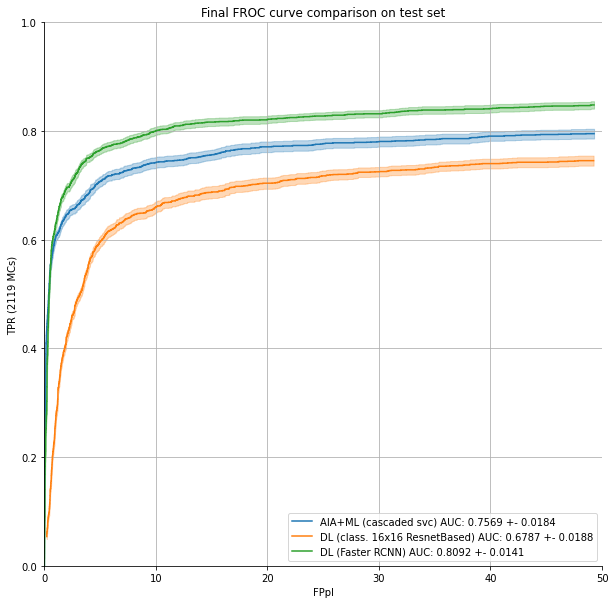

In [11]:
plot_several_bootstrapped_frocs(bootstraped_results)

 67%|██████▋   | 2/3 [10:54<05:28, 328.80s/it]/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
100%|██████████| 3/3 [19:17<00:00, 385.92s/it]


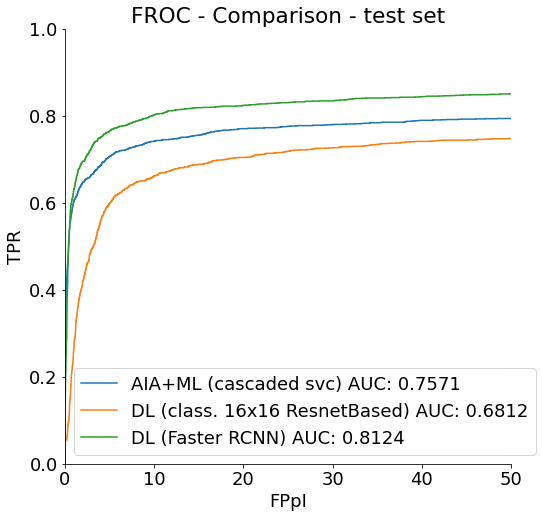

In [12]:
base_path = repo_path.parent / 'detections_dl'
models = {
    'AIA+ML (cascaded svc)': f'aia_ml_cascaded_svc_{SET}',
    'DL (class. 16x16 ResnetBased)': f'16_net2_07_{SET}',
    'DL (Faster RCNN)': f'dns121ptr0_{SET}'
}
frocs = {}
for name, model in tqdm(models.items()):
    path = Path(base_path)/model
    froc_df = pd.read_csv(path/'froc_df.csv')
    tprs, fpis, ths = froc_curve(froc_df, cut_on_50fpi=True)
    frocs[name] = {'tprs': tprs, 'fpis': fpis, 'ths': ths}
plot_several_frocs(frocs, title=f'FROC - Comparison - {SET} set', cut_on_50fpi=True)

## Comparison of Computation Time

100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


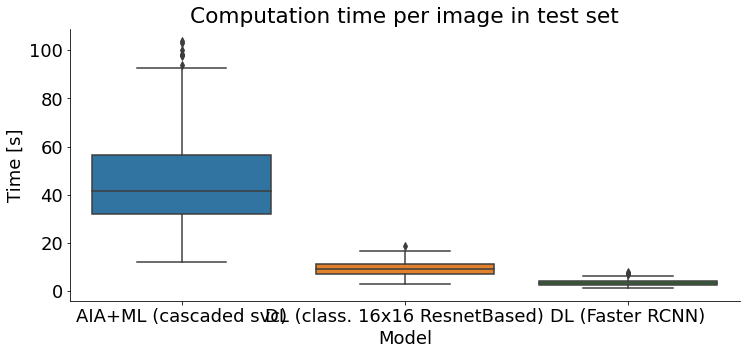

In [13]:
base_path = repo_path.parent / 'detections_dl'
models = {
    'AIA+ML (cascaded svc)': f'aia_ml_cascaded_svc_{SET}',
    'DL (class. 16x16 ResnetBased)': f'16_net2_07_{SET}',
    'DL (Faster RCNN)': f'dns121ptr0_{SET}'
}
times = {}
for name, model in tqdm(models.items()):
    path = Path(base_path)/model/'times.p'
    with open(path, 'rb') as f:
        time = pickle.load(f)
    times[name] = time
times = pd.DataFrame(times)
plt.figure(figsize=(12,5))
plt.title(f'Computation time per image in {SET} set')
sns.boxplot(x="variable", y="value", data=pd.melt(times))
plt.ylabel('Time [s]')
plt.xlabel('Model')
sns.despine()

## Comparison of Visualizations

In [14]:
# a flag that defines if to display some example images below with dehazing as preprocessing for better vizualisation
dehaze_example_imates = True

Generating detections for AIA+ML (cascaded svc)
Generating detections for DL (class. 16x16 ResnetBased)


100%|██████████| 16/16 [00:05<00:00,  3.11it/s]


Generating detections for DL (Faster RCNN)


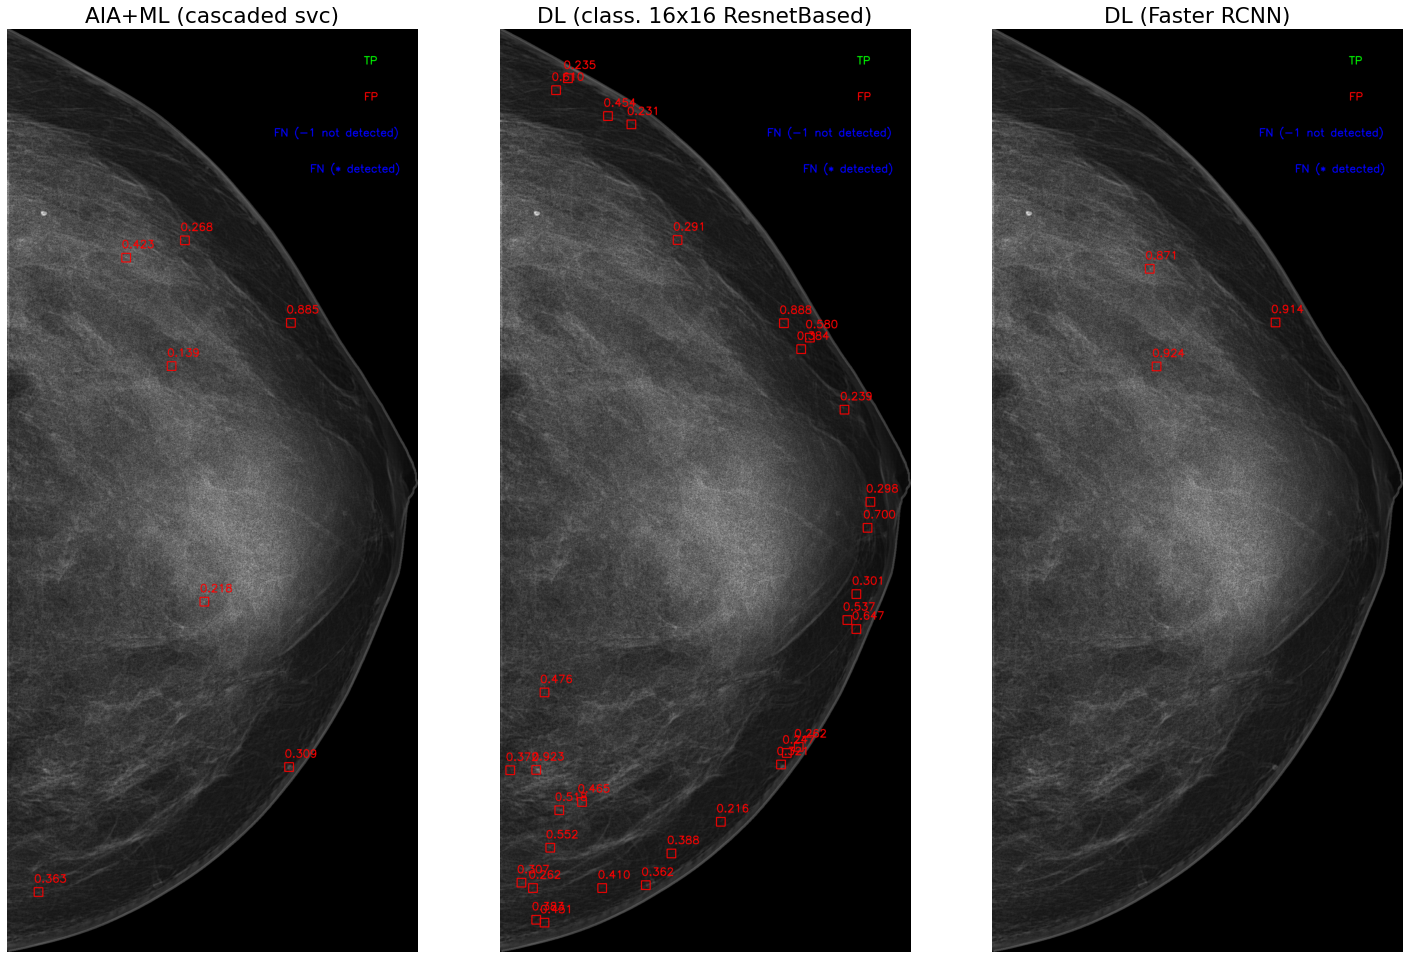

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# get image
idx = 4
db_sample = db[idx]
image = db_sample['img']
image_id = db_sample['img_id']
image_mask = db_sample['lesion_mask']

detections = {}
detection_images = {}
detectors = {
    'AIA+ML (cascaded svc)': detector_aia_ml,
    'DL (class. 16x16 ResnetBased)': detector_dlcl,
    'DL (Faster RCNN)': detector_dldet
}
thresholds = {
    'AIA+ML (cascaded svc)': 0.13444709378395178,
    'DL (class. 16x16 ResnetBased)': 0.21540279686450958,
    'DL (Faster RCNN)': 0.792923092842102
}

fig, ax = plt.subplots(1, 3, figsize=(25, 25))
for k, (name, detector) in enumerate(detectors.items()):
    # get detections
    print(f'Generating detections for {name}')
    model_detections = detector.detect(image)
    # reformat detections
    if 'ML' in name:
        model_detections_centers_and_radius = np.stack(
            model_detections['candidate_coordinates'].values).astype(int)
        model_detections_centers_scores = model_detections['confidence'].values.reshape(-1, 1)
        # retain the centers and scores:
        detections[name] = np.concatenate(
            [model_detections_centers_and_radius, model_detections_centers_scores], axis = 1)
    else:
        model_detections_centers = model_detections[:, 0:2].astype(int)
        model_detections_scores = model_detections[:, -1].reshape(-1, 1)
        model_detections_radius = np.ones(model_detections_scores.shape) * 7
        detections[name] = np.concatenate(
            [model_detections_centers, model_detections_radius, model_detections_scores],
            axis = 1
        )
    # generate the images
    if dehaze_example_imates:
        dehazed_img = dehaze(image/image.max(), 0.9, 11, eps=1e-5)
    else:
        dehazed_img = image
    image_ovl = add_detections_overlay(
        255*(dehazed_img/dehazed_img.max()), detections[name], image_mask, conf_thr=thresholds[name], k=10, need_labeling = True)
    image_ovl = cv2.cvtColor(image_ovl, cv2.COLOR_BGR2RGB)
    # plot
    ax[k].set_title(name)
    ax[k].imshow(image_ovl)
    detection_images[name] = image_ovl
    ax[k].axis('off')
plt.show()

In [17]:
# for k, img in detection_images.items():
#     cv2.imwrite( k+'.png', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

## Comparison of scores distribution

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


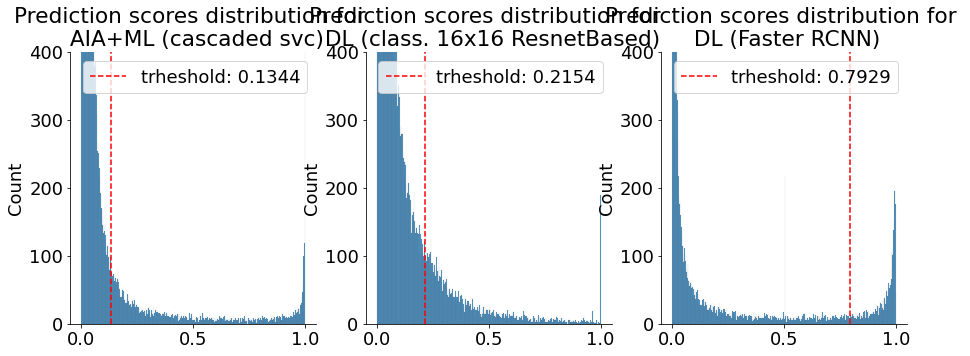

In [18]:
base_path = repo_path.parent / 'detections_dl'
models = {
    'AIA+ML (cascaded svc)': f'aia_ml_cascaded_svc_{SET}',
    'DL (class. 16x16 ResnetBased)': f'16_net2_07_{SET}',
    'DL (Faster RCNN)': f'dns121ptr0_{SET}'
}
thresholds = {
    'AIA+ML (cascaded svc)': 0.13444709378395178,
    'DL (class. 16x16 ResnetBased)': 0.21540279686450958,
    'DL (Faster RCNN)': 0.792923092842102
}
frocs = {}
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for k, (name, model) in enumerate(models.items()):
    path = Path(base_path)/model
    froc_df = pd.read_csv(path/'froc_df.csv')
    ax[k].set_title(f'Prediction scores distribution for \n {name}')
    sns.histplot(froc_df.pred_scores.values, bins=500, binrange=[0, 1], ax=ax[k])
    ax[k].vlines(
        thresholds[name], 0, 1500, label=f'trheshold: {thresholds[name]:.4f}', color='r', ls='--')
    sns.despine()
    ax[k].set_ylim([0, 400])
    ax[k].legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


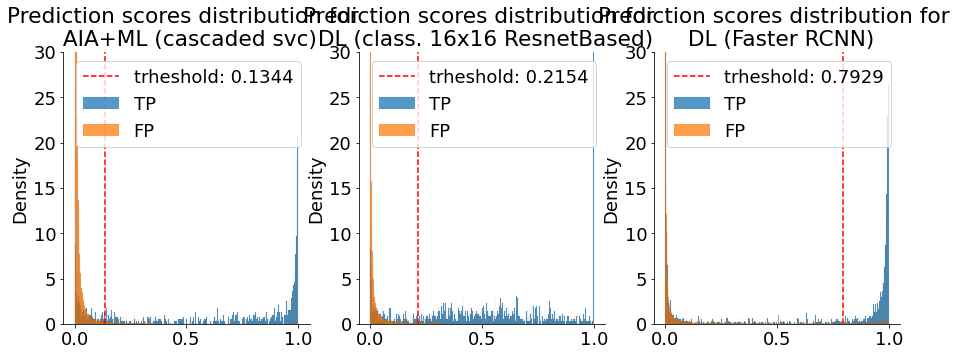

In [19]:
cmap = plt.get_cmap("tab10")

base_path = repo_path.parent / 'detections_dl'
models = {
    'AIA+ML (cascaded svc)': f'aia_ml_cascaded_svc_{SET}',
    'DL (class. 16x16 ResnetBased)': f'16_net2_07_{SET}',
    'DL (Faster RCNN)': f'dns121ptr0_{SET}'
}
thresholds = {
    'AIA+ML (cascaded svc)': 0.13444709378395178,
    'DL (class. 16x16 ResnetBased)': 0.21540279686450958,
    'DL (Faster RCNN)': 0.792923092842102
}
frocs = {}
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for k, (name, model) in enumerate(models.items()):
    path = Path(base_path)/model
    froc_df = pd.read_csv(path/'froc_df.csv')
    for m, label in enumerate(['TP', 'FP']):
        ax[k].set_title(f'Prediction scores distribution for \n {name}')
        sns.histplot(froc_df.loc[froc_df.label==label, 'pred_scores'].values,
                     bins=500, binrange=[0, 1], ax=ax[k], color = cmap(m), stat="density", label=label)
    ax[k].vlines(
        thresholds[name], 0, 1500, label=f'trheshold: {thresholds[name]:.4f}', color='r', ls='--')
    sns.despine()
    ax[k].set_ylim([0, 30])
    ax[k].legend()
plt.show()

## In depth analysis of some examples

##### Adavanced Image Analysis + Machine Learning (Casacaded SVMs)


 TP with low confidence


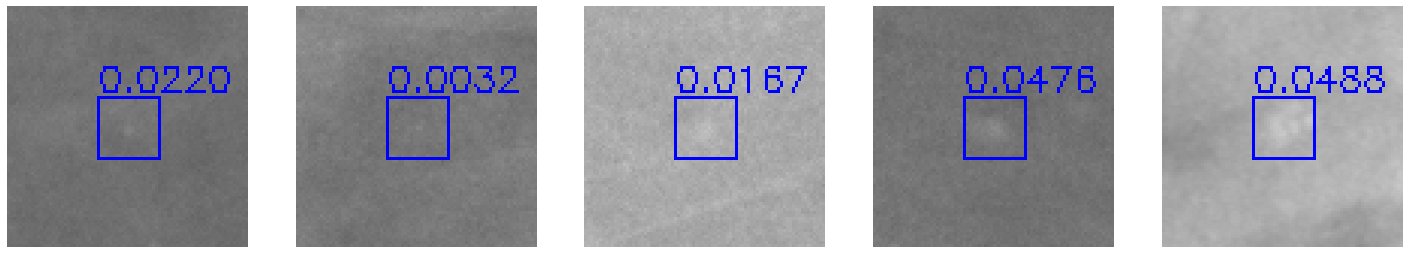


 TP with high confidence


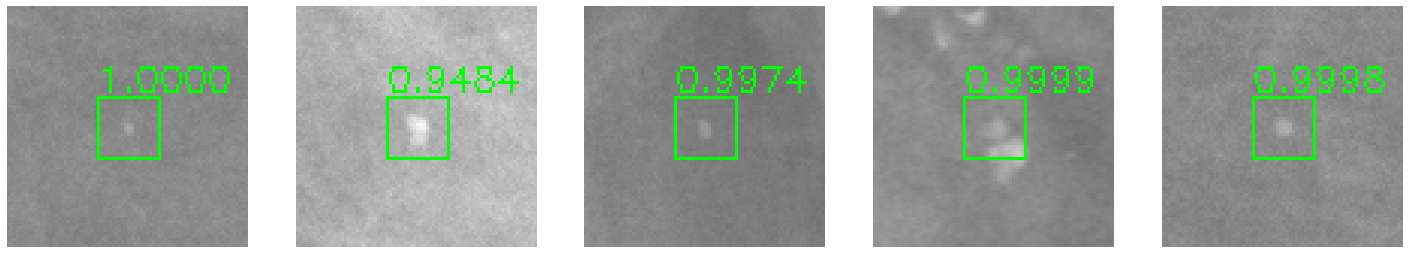


 FP with low confidence


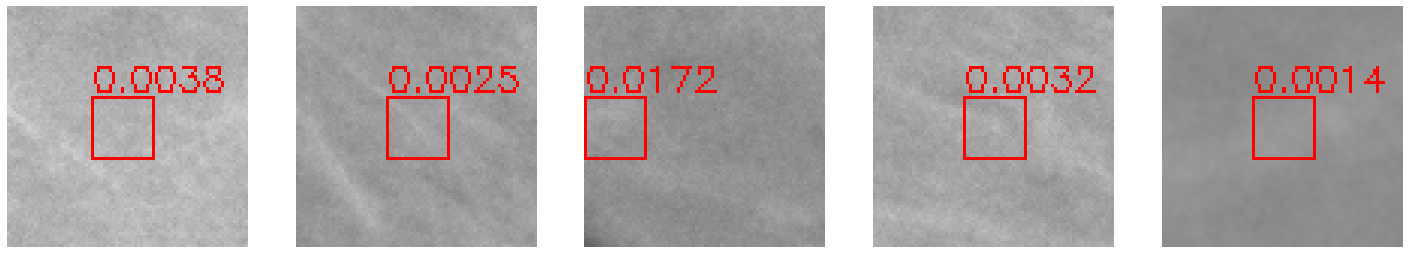


 FP with high confidence


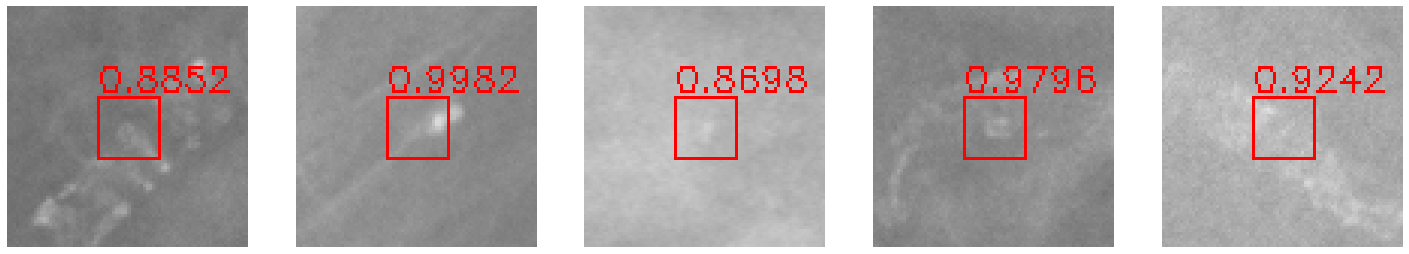


 FN


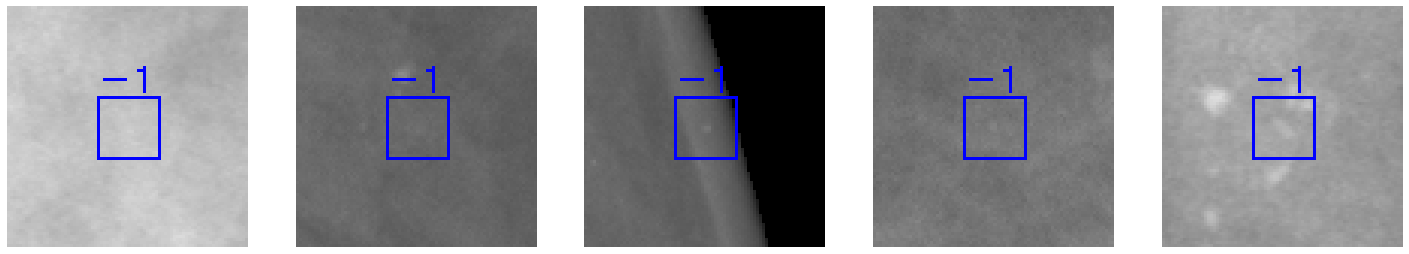

In [20]:
print('\n TP with low confidence')
plot_random_examples_of_label(db, froc_dfs_aia_ml, 'TP', 0.1, False)
print('\n TP with high confidence')
plot_random_examples_of_label(db, froc_dfs_aia_ml, 'TP', 0.8, True)
print('\n FP with low confidence')
plot_random_examples_of_label(db, froc_dfs_aia_ml, 'FP', 0.1, False)
print('\n FP with high confidence')
plot_random_examples_of_label(db, froc_dfs_aia_ml, 'FP', 0.8, True)
print('\n FN')
plot_random_examples_of_label(db, froc_dfs_aia_ml, 'FN', 0.1, True)

### Deep Learning (Detection by classification in sliding window fashion)


 TP with low confidence


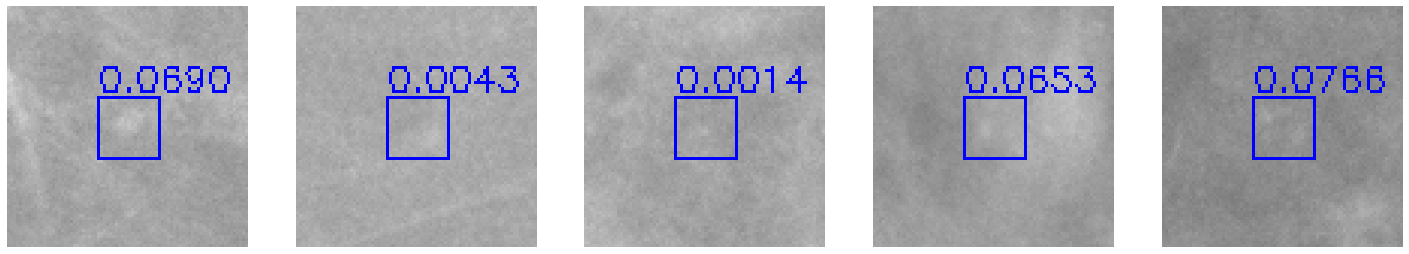


 TP with high confidence


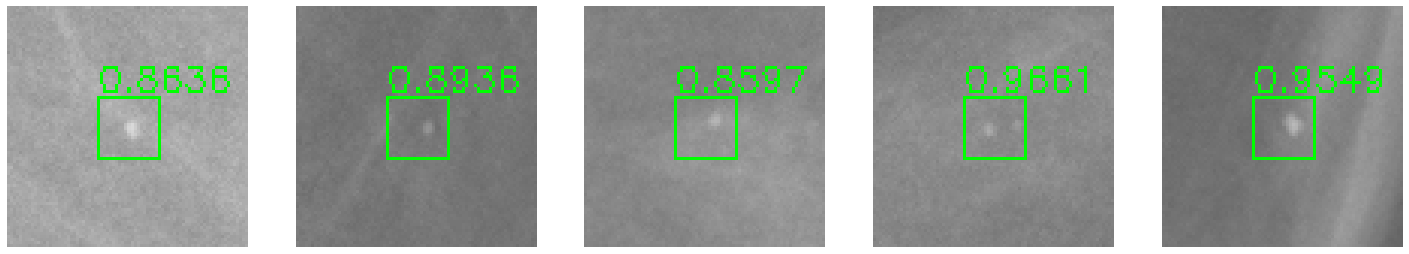


 FP with low confidence


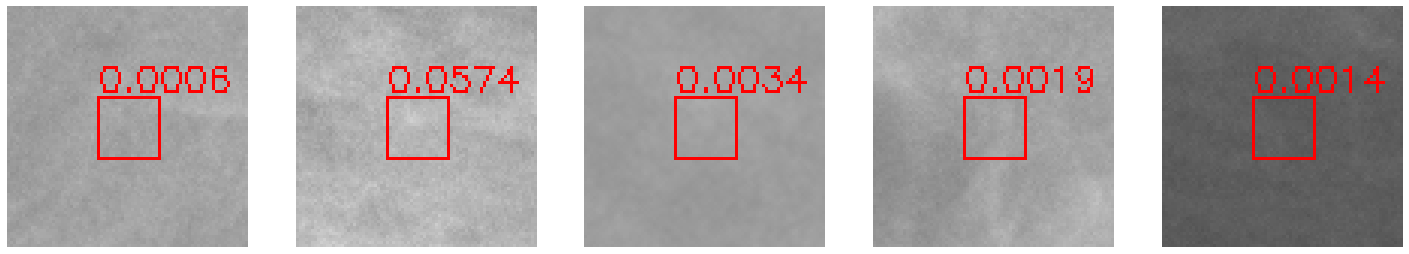


 FP with high confidence


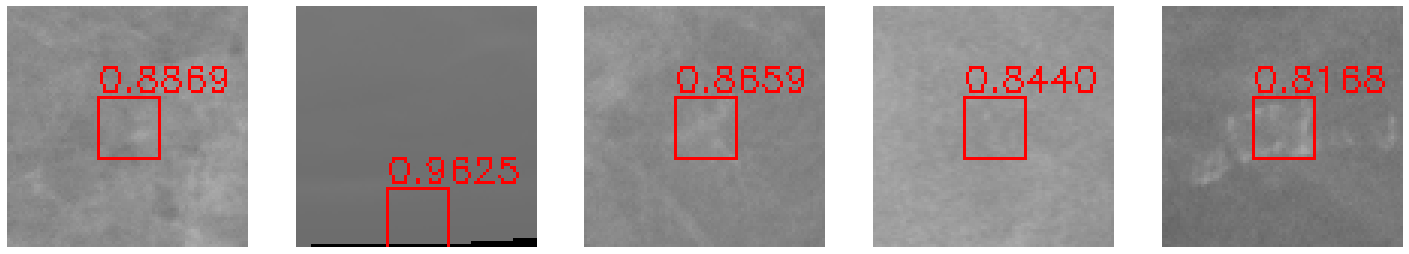


 FN


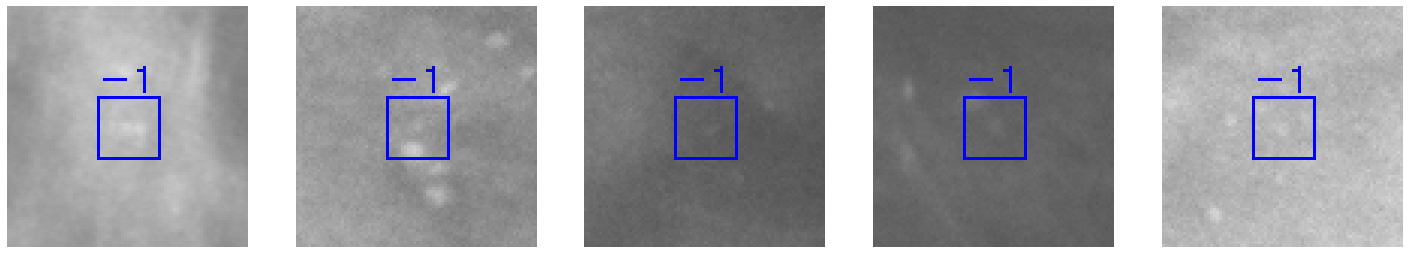

In [21]:
print('\n TP with low confidence')
plot_random_examples_of_label(db, froc_dfs_dlcl, 'TP', 0.1, False)
print('\n TP with high confidence')
plot_random_examples_of_label(db, froc_dfs_dlcl, 'TP', 0.8, True)
print('\n FP with low confidence')
plot_random_examples_of_label(db, froc_dfs_dlcl, 'FP', 0.1, False)
print('\n FP with high confidence')
plot_random_examples_of_label(db, froc_dfs_dlcl, 'FP', 0.8, True)
print('\n FN')
plot_random_examples_of_label(db, froc_dfs_dlcl, 'FN', 0.1, True)

### Deep Learning (Detection using Faster RCNN in slidin window fashion)


 TP with low confidence


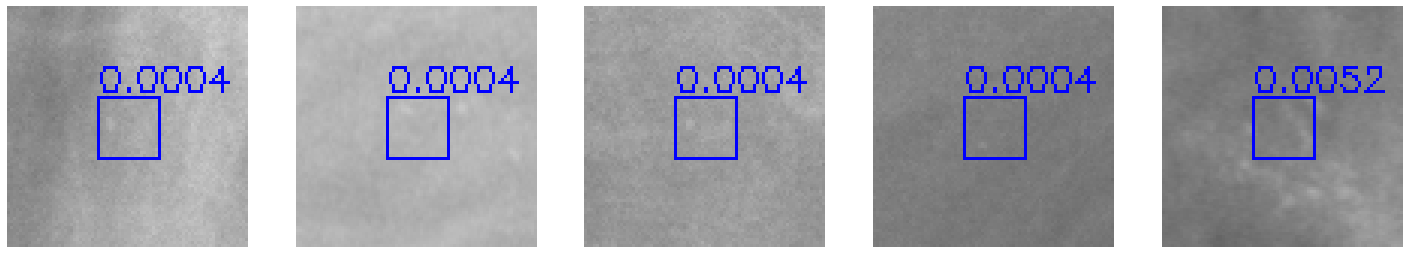


 TP with high confidence


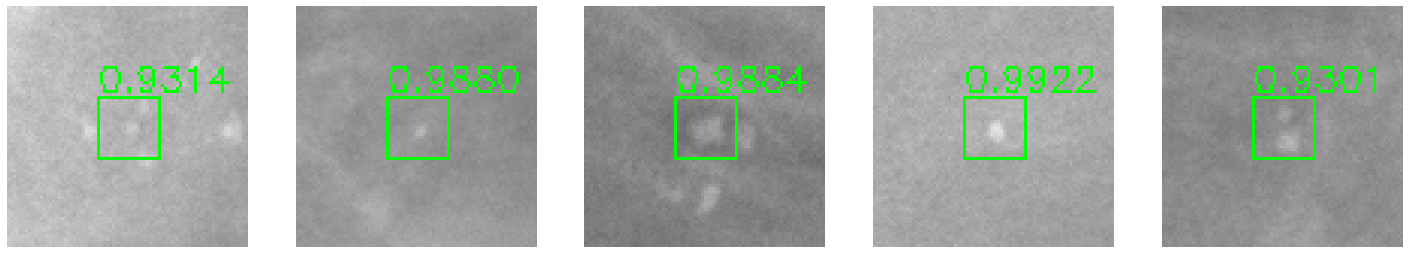


 FP with low confidence


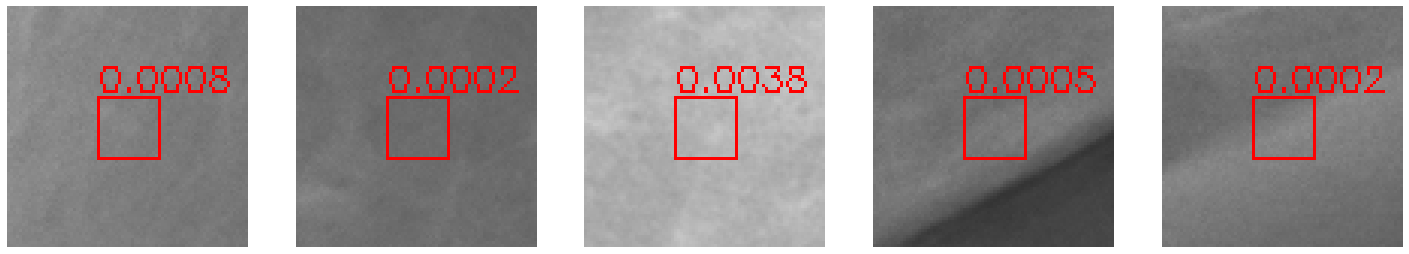


 FP with high confidence


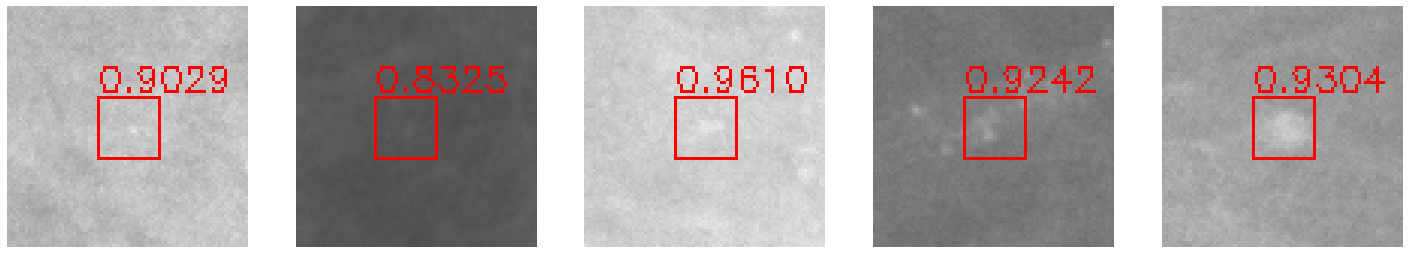


 FN


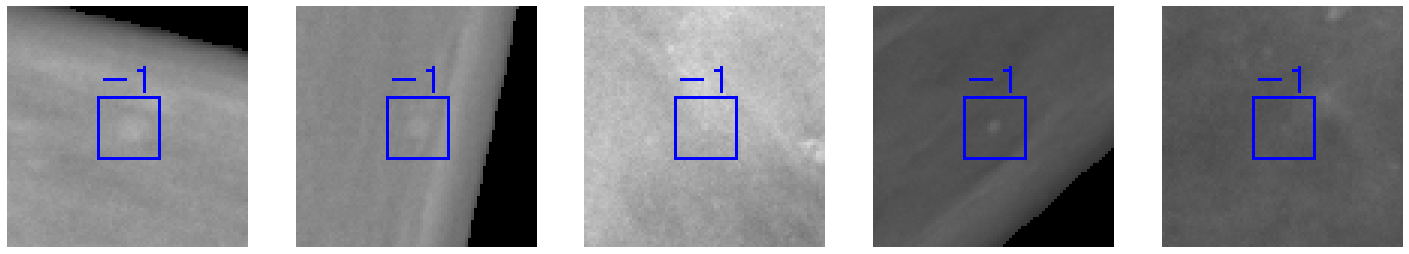

In [22]:
print('\n TP with low confidence')
plot_random_examples_of_label(db, froc_dfs_dldet, 'TP', 0.1, False)
print('\n TP with high confidence')
plot_random_examples_of_label(db, froc_dfs_dldet, 'TP', 0.8, True)
print('\n FP with low confidence')
plot_random_examples_of_label(db, froc_dfs_dldet, 'FP', 0.1, False)
print('\n FP with high confidence')
plot_random_examples_of_label(db, froc_dfs_dldet, 'FP', 0.8, True)
print('\n FN')
plot_random_examples_of_label(db, froc_dfs_dldet, 'FN', 0.1, True)